# Importing Required Libraries

In [45]:
#!pip install nltk

In [46]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

import warnings

import pickle
import time

import re
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from tqdm import tqdm
from string import punctuation

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MultiLabelBinarizer 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron 
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection 
from sklearn.metrics import make_scorer
from sklearn.metrics import hamming_loss

import logging

from scipy.sparse import hstack

warnings.filterwarnings("ignore")

# Load the Data Set

In [47]:
tags = pd.read_csv("Tags.csv",encoding="ISO-8859-1",dtype ={'Tag':str})
tags.head()

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


In [48]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3750994 entries, 0 to 3750993
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Id      int64 
 1   Tag     object
dtypes: int64(1), object(1)
memory usage: 57.2+ MB


In [49]:
ques = pd.read_csv("Questions.csv",encoding = "ISO-8859-1")
ques.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [50]:
ques.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1264216 entries, 0 to 1264215
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Id            1264216 non-null  int64  
 1   OwnerUserId   1249762 non-null  float64
 2   CreationDate  1264216 non-null  object 
 3   ClosedDate    55959 non-null    object 
 4   Score         1264216 non-null  int64  
 5   Title         1264216 non-null  object 
 6   Body          1264216 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 67.5+ MB


# Handling Missing Value

In [51]:
tags['Tag'] = tags['Tag'].astype(str)
grouped_tags = tags.groupby("Id")['Tag'].apply(lambda tags:' '.join(tags))
grouped_tags.reset_index()

,Id,Tag
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction
...,...,...
1264211,40143210,php .htaccess
1264212,40143300,google-bigquery
1264213,40143340,android android-studio
1264214,40143360,javascript vue.js


In [52]:
grouped_tags.head()

Id
80                            flex actionscript-3 air
90       svn tortoisesvn branch branching-and-merging
120                               sql asp.net sitemap
180    algorithm language-agnostic colors color-space
260           c# .net scripting compiler-construction
Name: Tag, dtype: object

In [53]:
ques.drop(columns=['OwnerUserId','CreationDate','ClosedDate'],inplace=True)
ques = ques.merge(grouped_tags, on='Id')

In [54]:
ques.head()

,Id,Score,Title,Body,Tag
0,80,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,90,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,120,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,180,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,260,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction


In [55]:
ques = ques[ques['Score']>5]

In [56]:
ques.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72950 entries, 0 to 1264205
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      72950 non-null  int64 
 1   Score   72950 non-null  int64 
 2   Title   72950 non-null  object
 3   Body    72950 non-null  object
 4   Tag     72950 non-null  object
dtypes: int64(2), object(3)
memory usage: 3.3+ MB


In [57]:
ques.drop(columns = ['Id','Score'],inplace = True)
ques.head()

,Title,Body,Tag
0,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction


In [58]:
del tags
del grouped_tags

In [59]:
ques['Tag'] = ques['Tag'].apply(lambda x:x.split())
all_tags = [item for sublist in ques['Tag'].values for item in sublist]

In [60]:
len(all_tags)

224129

In [61]:
unique_tags = list(set(all_tags))

In [62]:
len(unique_tags)

14883

In [63]:
from collections import Counter
ques.head()

,Title,Body,Tag
0,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,"[flex, actionscript-3, air]"
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,"[svn, tortoisesvn, branch, branching-and-merging]"
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net, sitemap]"
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,"[algorithm, language-agnostic, colors, color-s..."
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net, scripting, compiler-construction]"


In [64]:
counter = Counter(all_tags)
most_occur = counter.most_common(100)

In [65]:
tags = [i[0] for i in most_occur]
count = [i[1] for i in most_occur]
tags[:5],count[:5]

(['c#', 'java', 'javascript', 'android', 'python'],
 [6907, 6862, 5560, 5052, 4442])

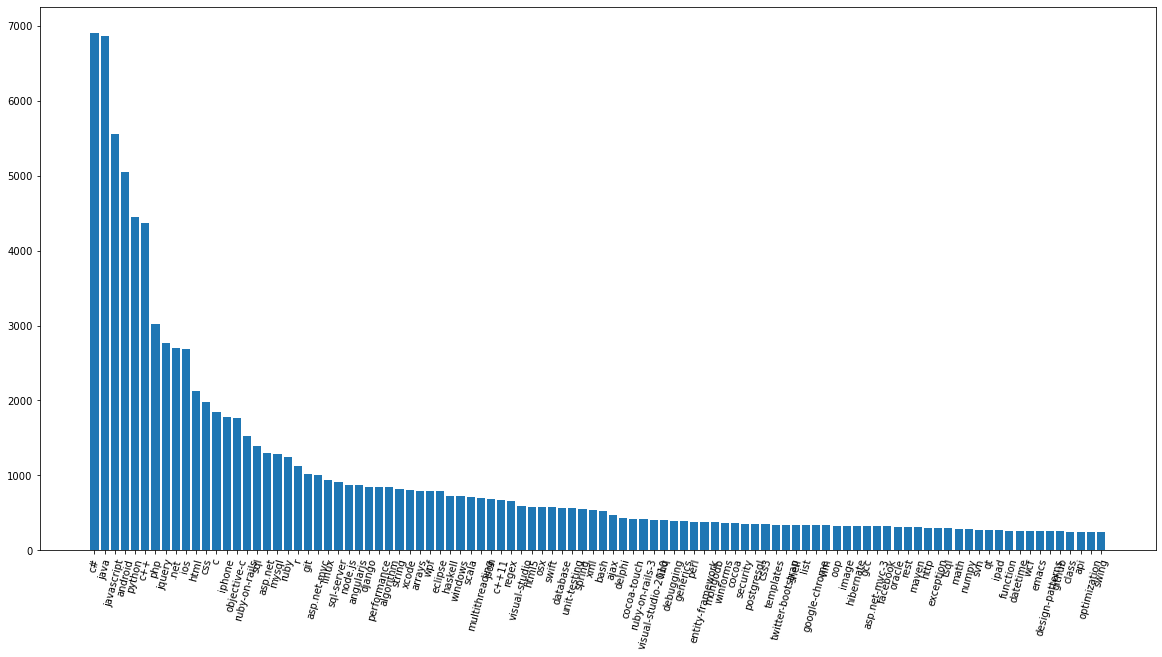

In [66]:
x = np.arange(len(most_occur))
fig, ax = plt.subplots(figsize=(20, 10))
plt.bar(x, height= count) 
plt.xticks(x, tags, rotation=75)
plt.show()

In [67]:
def most_common(x):
    tags_filtered = []
    for i in range(0, len(x)):
        if x[i] in tags:
            tags_filtered.append(x[i])
    return tags_filtered

In [68]:
ques['Tag'] = ques['Tag'].apply(lambda x: most_common(x))
ques['Tag'] = ques['Tag'].apply(lambda x: x if len(x)>0 else None)

In [69]:
ques.shape

(72950, 3)

In [70]:
ques.dropna(subset=['Tag'], inplace=True)
ques.shape

(63167, 3)

In [71]:
ques.head()

,Title,Body,Tag
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,[svn]
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net]"
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,[algorithm]
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net]"
5,Should I use nested classes in this case?,<p>I am working on a collection of classes use...,"[c++, oop, class]"


In [72]:
# Converting html to text in the body
ques['Body'] = ques['Body'].apply(lambda x: BeautifulSoup(x).get_text()) 

In [73]:
#print(dir(nltk.download()))

In [74]:
#nltk.download('popular')

In [75]:
token=ToktokTokenizer()
punct = '!"#$%&\'()*+,./:;<=>?@[\]^_`{|}~'

def clean_text(text):
  text = text.lower()
  text = re.sub(r"what's", "what is ", text)
  text = re.sub(r"\'s", " ", text)
  text = re.sub(r"\'ve", " have ", text)
  text = re.sub(r"can't", "can not ", text)
  text = re.sub(r"n't", " not ", text)
  text = re.sub(r"i'm", "i am ", text)
  text = re.sub(r"\'re", " are ", text)
  text = re.sub(r"\'d", " would ", text)
  text = re.sub(r"\'ll", " will ", text)
  text = re.sub(r"\'scuse", " excuse ", text)
  text = re.sub(r"\'\n", " ", text)
  text = re.sub(r"\'\xa0", " ", text)
  text = re.sub('\s+', ' ', text)
  text = text.strip(' ')
  return text

def strip_list_noempty(mylist):
  newlist = (item.strip() if hasattr(item, 'strip') else item for item in mylist)
  return [item for item in newlist if item != '']

def clean_punct(text): 
  words=token.tokenize(text)
  punctuation_filtered = []
  regex = re.compile('[%s]' % re.escape(punct))
  remove_punctuation = str.maketrans(' ', ' ', punct)
  for w in words:
      if w in tags:
          punctuation_filtered.append(w)
      else:
          punctuation_filtered.append(regex.sub('', w))

  filtered_list = strip_list_noempty(punctuation_filtered)

  return ' '.join(map(str, filtered_list))

lemma=WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def lemitizeWords(text):
    words=token.tokenize(text)
    listLemma=[]
    for w in words:
        x=lemma.lemmatize(w, pos="v")
        listLemma.append(x)
    return ' '.join(map(str, listLemma))

def stopWordsRemove(text):
    
    stop_words = set(stopwords.words("english"))
    
    words=token.tokenize(text)
    
    filtered = [w for w in words if not w in stop_words]
    
    return ' '.join(map(str, filtered))

In [76]:
def combine(new_df):
  new_df['Body'] = new_df['Body'].apply(lambda x: clean_text(x))
  print(1)
  new_df['Body'] = new_df['Body'].apply(lambda x: clean_punct(x))
  print(2)
  new_df['Body'] = new_df['Body'].apply(lambda x: lemitizeWords(x)) 
  print(3)
  new_df['Body'] = new_df['Body'].apply(lambda x: stopWordsRemove(x))
  print(4)
  new_df['Title'] = new_df['Title'].apply(lambda x: str(x))
  print(5)
  new_df['Title'] = new_df['Title'].apply(lambda x: clean_text(x)) 
  print(6)
  new_df['Title'] = new_df['Title'].apply(lambda x: clean_punct(x)) 
  print(7)
  new_df['Title'] = new_df['Title'].apply(lambda x: lemitizeWords(x)) 
  print(8)
  new_df['Title'] = new_df['Title'].apply(lambda x: stopWordsRemove(x))
  return new_df

In [77]:
ques = combine(ques)
ques.head()

1
2
3
4
5
6
7
8


,Title,Body,Tag
1,good branch merge tutorials tortoisesvn,really good tutorials explain branch merge apa...,[svn]
2,asp.net site map,anyone get experience create sql-based asp.net...,"[sql, asp.net]"
3,function create color wheel,something pseudo-solved many time never quite ...,[algorithm]
4,add script functionality .net applications,little game write c use database back-end trad...,"[c#, .net]"
5,use nest class case,work collection class use video playback recor...,"[c++, oop, class]"


In [78]:
y = ques['Tag']
ques = ques.values
X = []

for i in tqdm(ques):
  X.append(i[0]+' '+i[1])

100%|████████████████████████████████████████████████████████████████████████| 63167/63167 [00:00<00:00, 336139.68it/s]


In [79]:
multilabel_binarizer = MultiLabelBinarizer()
Y = multilabel_binarizer.fit_transform(y)

In [80]:
len(X),Y.shape

(63167, (63167, 100))

In [81]:
X[0]

'good branch merge tutorials tortoisesvn really good tutorials explain branch merge apache subversion better specific tortoisesvn client'

In [82]:
with open('X.pkl','wb') as f:
  pickle.dump(X, f)
with open('Y.pkl','wb') as f:
  pickle.dump(Y, f)